# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import joblib
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore")


## 1. Data Import

In [2]:
def csv_files(all_csv_files): 
    """Locate csv"""
    for path, folder, file_list in os.walk(os.getcwd()):
            if len(file_list) > 0:
                for file in file_list:
                    if file[-4:]  == ".csv":
                        all_csv_files.append(os.path.join(path, file))

main_dir = os.getcwd()

# Locate csvs
all_csv_files = []            

# Hamza
os.chdir('/media/hamza/289875229874EFA4/WORK/annotation/done/sentiments')
csv_files(all_csv_files )

# uamir
os.chdir('/home/hamza/Documents/umair')
csv_files(all_csv_files )

# Farrukh
os.chdir('/home/hamza/Documents/farrukh')
csv_files(all_csv_files )

all_csv_files = list(set(all_csv_files))


# Merging all csvs
frames = [] 
for csv_file in all_csv_files:
    frames.append(pd.read_csv(csv_file))

df = pd.concat(frames)

In [3]:
print(df.size)
df.head()

55550


,Text,Sentiment
0,Mobo pro only,Neutral
1,Ye liger card ka kya scene he.???,Neutral
2,Daraz per kafi saste me mil rhay hain....,Neutral
3,Inka original cards se performance me kitna fa...,Neutral
4,Muhammad Fahad ..... Kisi ne nhi btaya,Neutral


## 2. EDA

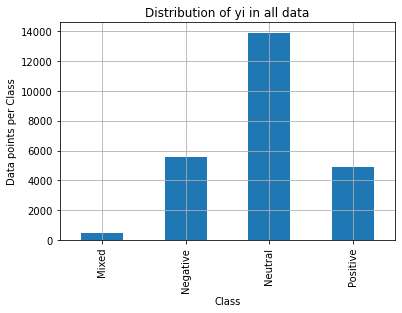

Number of data points in class 3 : 13904 ( 50.059 %)
Number of data points in class 2 : 5601 ( 20.166 %)
Number of data points in class 4 : 4912 ( 17.685 %)
Number of data points in class 1 : 477 ( 1.717 %)


In [4]:
def display_distribution(class_distribution, split_data_type, data_shape):
    my_colors = 'rgbkymc'
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title(f'Distribution of yi in {split_data_type} data')
    plt.grid()
    plt.show()
    
    # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    # -(class_distribution.values): the minus sign will give us in decreasing order
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data_shape*100), 3), '%)')

class_distribution = df['Sentiment'].value_counts().sort_index()
display_distribution(class_distribution=class_distribution, split_data_type="all", data_shape=df.shape[0])

In [5]:
print(df['Sentiment'].unique())
df.dropna(inplace=True)
df['Sentiment'].unique()

['Neutral' 'Positive' 'Negative' 'Mixed' nan]


array(['Neutral', 'Positive', 'Negative', 'Mixed'], dtype=object)

In [6]:
# Change column "Score" values 
## 1-5(1/2 => negative, 3 => neutral, 4/5 => positive) to
## 0-1(negative/positive)

def partition(x):
    """
    Score>3 a positive rating,
    Score<3 a negative rating.
    """
    if x == 'Positive':
        return 1
    elif x == 'Negative':
        return 2
    elif x == 'Mixed':
        return 3
    elif x == 'Neutral':
        return 4

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = df['Sentiment']
positiveNegative = actualScore.map(partition) 
df['Sentiment'] = positiveNegative

print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (24894, 2)


,Text,Sentiment
0,Mobo pro only,4
1,Ye liger card ka kya scene he.???,4
2,Daraz per kafi saste me mil rhay hain....,4
3,Inka original cards se performance me kitna fa...,4
4,Muhammad Fahad ..... Kisi ne nhi btaya,4


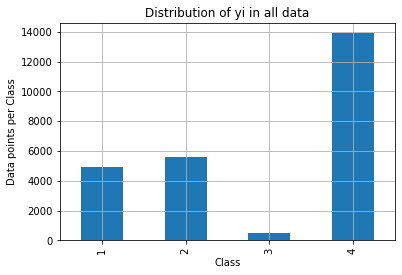

Number of data points in class 4 : 13904 ( 55.853 %)
Number of data points in class 2 : 5601 ( 22.499 %)
Number of data points in class 1 : 4912 ( 19.732 %)
Number of data points in class 3 : 477 ( 1.916 %)


In [7]:
class_distribution = df['Sentiment'].value_counts().sort_index()
display_distribution(class_distribution=class_distribution, split_data_type="all", data_shape=df.shape[0])

## 3. Data Preprocessing

In [8]:
def decontracted(word):
    # https://www.kaggle.com/smat26/sentiment-analysis-on-roman-urdu
    import re
    import bs4 as bs
    # import re

    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    word = re.sub(r'ee+', r'i', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[bcdefghijklmnopqrtuvwxyz]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[acefghijlmnoqrstuvwxyz]h', word):
        word = re.sub(r'h', '', word)
        word = re.sub(r'k', r'q', word)
        
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.', '', word)
    word = re.sub(r'\\', ' ', word)
    word = re.sub(r'\\x\.+', '', word)
    word = re.sub(r'\d', '', word)
    word = re.sub(r'^_.', '', word)
    word = re.sub(r'_', ' ', word)
    word = re.sub(r'^ ', '', word)
    word = re.sub(r' $', '', word)
    word = re.sub(r'\?', '', word)
    
    # Remove HTML tags
    word = re.sub(r"http\S+", "", word)
    word = bs.BeautifulSoup(word, 'lxml').get_text()

    # Remove numeric values including alphanueric value
    word = re.sub("\S*\d\S*", "", word).strip()

    # Remove special chars
    word = re.sub('[^A-Za-z]+', ' ', word)
    return word.lower()
    
def lemmatizing(text):
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize

    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def text_preprocessing(df_text):
    from tqdm import tqdm
    
    preprocessed_msg = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df_text.values):
        # Remove undesired chars
        sentance = decontracted(sentance)
        sentance = lemmatizing(sentance)

        # Stop words
        ## https://deepnote.com/@umaimakhh/Sentimental-Analysis-on-Roman-Urdu-CYPLZfCxTjWGLxWzS2BaDg
        ## some words like Mein - Ma - Maa
        stopwords= ['uski', 'krna', 'kch', 'gai', 'raha', 'you', 'le', 'ki', 'krta', 'ga', 'jo', 'haan', 'de',
                    'hun', 'ho', 'meri', 'is', 'nai', 'jee', 'lg', 'dain', 'hoa', 'jati', 'jana', 'rahi', 'kar', 'tou',
                    'photo', 'rha', 'ayi', 'wala', 'lye', 'kis', 'sy', 'ne', 'wohi', 'gy', 'gi', 'ny', 'hi', 'ab', 'gaya',
                    'je', 'hotay', 'jata', 'pe', 'hota', 'aye', 'me', 'tha', 'rahay', 'rhy', 'gya', 'us', 'thay', 'bhi',
                    'liye', 'sent', 'hai', 'aur', 'thi', 'jye', 'dono', 'phr', 'yehi', 'to', 'na', 'main', 'abi', 'hum',
                    'koi', 'hova', 'hain', 'ja', 'un', 'par', 'kafi', 'kr', 'hy', 'karna', 'h', 'krny', 'wo', 'kay', 'acha',
                    'mil', 'jb', 'ya', 'kya', 'ai', 'kuch', 'se', 'woh', 'thy', 'ap', 'houn', 'hay', 'sb', 'ka', 'he', 'han',
                    'chal', 'in', 'waisay', 'aese', 'hui', 'or', 'tu', 'ko', 'yeh']

        
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)

        # Append processed sentense to list
        preprocessed_msg.append(sentance.strip())
        
    return preprocessed_msg
        
df['processed_text'] = text_preprocessing(df['Text'].astype("str"))
df.drop('Text', axis=1, inplace=True)
df.head()

100%|███████████████████████████████████| 24894/24894 [00:20<00:00, 1212.75it/s]


,Sentiment,processed_text
0,4,mobo pro only
1,4,ye liger crd scene
2,4,draz per qafi saste ray aen
3,4,inka original crds performance kitna frq
4,4,moammad faad kisi ni btaya


In [9]:
os.chdir(main_dir)
joblib.dump(df, 'data/01_processed_data.joblib')

['data/01_processed_data.joblib']

## 4. Handling Imbalanced Data

In [10]:
df = joblib.load('data/01_processed_data.joblib')

In [3]:
import nlpaug.augmenter.word.context_word_embs as aug

augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [12]:
df['Sentiment'].value_counts()

4    13904
2     5601
1     4912
3      477
Name: Sentiment, dtype: int64

#### Data Augmentation

In [5]:
def augmentMyData(df, augmenter, repetitions=1, samples=200):
    from sklearn.utils import shuffle
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df['Sentiment'] == 3].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df['processed_text'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'Sentiment': 3,
        'processed_text': augmented_texts
    }
    
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [6]:
aug_df = augmentMyData(df, augmenter, samples=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [2]:
# aug_df['Sentiment'].value_counts()

In [8]:
joblib.dump(aug_df, 'data/02_aug_data.joblib')

['data/02_aug_data.joblib']

### Donwsampling

In [2]:
df = joblib.load('data/01_processed_data.joblib')#02_aug_data.joblib')

In [3]:
df1 = df[df['Sentiment']==1][:4920]
df2 = df[df['Sentiment']==2][:4920]
# df3 = df[df['Sentiment']==3][:4920]
df4 = df[df['Sentiment']==4][:4920]


df.loc[df['Sentiment']==1,"Class"] = 0
df.loc[df['Sentiment']==2,"Class"] = 1
df.loc[df['Sentiment']==4,"Class"] = 2

dff = pd.concat([df1, df2,df4])# df3, df4])
# dff = dff.sample(frac=1).reset_index(drop=True)

In [4]:
dff['Sentiment'].value_counts()

2    4920
4    4920
1    4912
Name: Sentiment, dtype: int64

In [5]:
joblib.dump(dff, 'data/03_resampled_data.joblib')

['data/03_resampled_data.joblib']

In [2]:
df = joblib.load('data/03_resampled_data.joblib')

In [3]:
df['Sentiment'].value_counts()

2    4920
4    4920
1    4912
Name: Sentiment, dtype: int64

In [4]:
df.loc[df['Sentiment']==1,"Sentiment"] = 0 # positive
df.loc[df['Sentiment']==2,"Sentiment"] = 1 # negative
df.loc[df['Sentiment']==4,"Sentiment"] = 2 # neural

df['Sentiment'].value_counts()

1    4920
2    4920
0    4912
Name: Sentiment, dtype: int64

In [5]:
Y = df['Sentiment'].values
X = df['processed_text']

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# Random sampling
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20) 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_train = X_train.toarray()
print(X_train.shape)

X_test = vectorizer.transform(X_test)
X_test = X_test.toarray()
print(X_test.shape)

(11801, 1000)
(2951, 1000)


In [6]:
def BestMLAlgo(nlp_model, x_train, x_test, y_train, y_test):
    """Identify best Algo on given dataset"""
    from prettytable import PrettyTable
    
    table = PrettyTable()
    table.field_names = ["Vect", "Model", "Accuracy", "Precision", "Recall", "F1Score", "Log loss", "Roc Auc"]
                        
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.linear_model import SGDClassifier
    from sklearn.calibration import CalibratedClassifierCV
    import xgboost
    from sklearn import svm
    from sklearn.metrics import precision_score, accuracy_score, roc_auc_score,\
                                roc_curve, auc, log_loss, recall_score
    
    base_models = {
        'kNN': KNeighborsClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Log. Reg.': LogisticRegression(),
        'SVM Linear': SGDClassifier(class_weight='balanced', penalty='l2', loss='hinge', random_state=42),
        'SVM Non-linear': svm.SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boost': GradientBoostingClassifier(),
        'Ada Boost': AdaBoostClassifier(),
        'xgboost': xgboost.XGBClassifier(),
    }          
        
    for model_name, model in base_models.items():
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_test)
        y_pred = model.predict(x_test)
            
        # Performance metrics
        accuracy        = round(accuracy_score(y_test, y_pred), 2)
        precision       = round(precision_score(y_test, y_pred, average='micro'), 2)
        recall          = round(recall_score(y_test, y_pred, average='micro'), 2)
        f1_score        = round((2*recall*precision)/(recall+precision), 2)
        loss            = round(log_loss(y_test, y_pred_proba, eps=1e-15), 2) # , labels=model.classes
        roc_auc         = round(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"), 2)        
        
        table.add_row([nlp_model, model_name, accuracy, precision, recall, f1_score, loss, roc_auc])
    print(table)

In [7]:
BestMLAlgo("TFIDF", X_train, X_test, y_train, y_test)

[10:35:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:37:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc \
                , accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csr import csr_matrix
import seaborn as sns

In [29]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    from sklearn.metrics import confusion_matrix

        
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()



In [25]:
def LR_Classifier(X_train, y_train, regOpt):
    cList = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, \
                        1, 10, 50, 100, 500, 1000, 5000, 10000])
    params_dict = [{'C': cList}]

    # Setting solver param
    if regOpt == "l1":
        sol = 'liblinear'
    elif regOpt == "l2":
        sol = 'lbfgs'
    lr_optimal = LogisticRegression(penalty=regOpt, solver=sol)
    
    grid = GridSearchCV(estimator=lr_optimal, 
                        param_grid=params_dict,
#                           param_distributions=params_dict, 
                        scoring='f1_micro', n_jobs=4, cv=5,  
                        return_train_score=True
                       )
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    plt.figure(figsize=(10.0, 8.0))
    plt.plot(np.log10(cList), train_auc, label='Train AUC micro vs C')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log10(cList), train_auc - train_auc_std, 
                          train_auc + train_auc_std, alpha=0.2, color='darkblue')
    
    plt.plot(np.log10(cList), cv_auc, label='CV AUC micro vs C')
    plt.gca().fill_between(np.log10(cList), cv_auc - cv_auc_std, 
                          cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
    
    plt.title('Area under  AUC vs C')
    plt.xlabel('C')
    plt.ylabel('Area')
    plt.legend(loc='lower left')
    plt.show()    
    
    return grid_result.best_estimator_.get_params()['C']

In [23]:
def LR_Classifier_Test(cValue, regOpt, X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params
    
    # Setting solver param
    if regOpt == "l1":
        sol = 'liblinear'
    elif regOpt == "l2":
        sol = 'lbfgs'
    
    lr_optimal = LogisticRegression(C=cValue, penalty=regOpt, solver=sol)
    lr_optimal.fit(X_train, y_train)

    # Prediction on training and test set using optimal classifier
    logProb_train = lr_optimal.predict_log_proba(X_train)
    logProb_test = lr_optimal.predict_log_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using C value for LR - ", cValue)
    print("Train accuracy for optimal LR ", round(accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal LR ", round(accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return lr_optimal, pred_train, pred_test, auc_score

In [31]:
def log_reg_applied(optimal_param, reg_opt, nlp_algorithm, X_train, y_train, X_test, y_test):
    classifier, pred_train, pred_test, auc_score = LR_Classifier_Test(
                                    optimal_param, reg_opt,
                                    X_train, y_train, X_test, y_test)
    
    print("Training Confusion Matrix")
    plot_confusion_matrix(y_train, pred_train)
    print('\n\n')

    print("Test Confusion Matrix")
    plot_confusion_matrix(y_test, pred_test)
        
    # Classification report 
    print(classification_report(y_test, pred_test))
    
    return classifier
# , pred_train, pred_test, auc_score

Optimal Parameters :  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


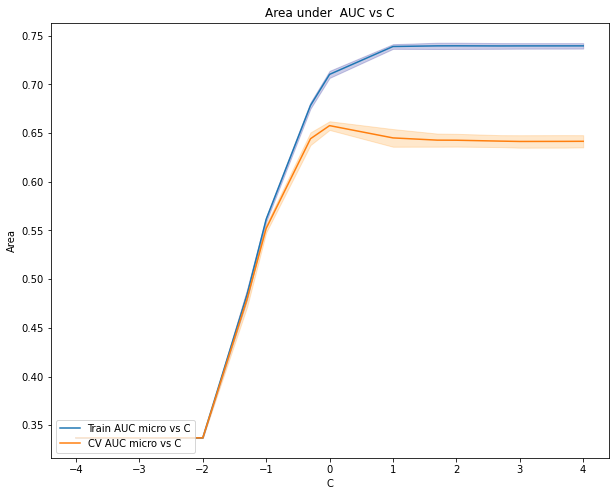

In [36]:
regularization_optimization = 'l1'
nlp_model = "TFIDF"

# Please write all the code with proper documentation
optimal_c = LR_Classifier(X_train, y_train, regularization_optimization)

Using C value for LR -  1.0
Train accuracy for optimal LR  70.83
Test accuracy for optimal LR  65.33


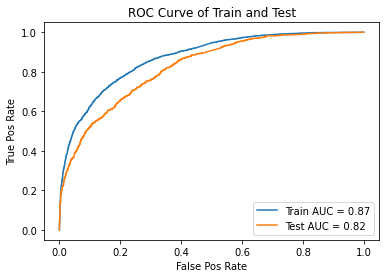

Training Confusion Matrix
-------------------- Confusion matrix --------------------


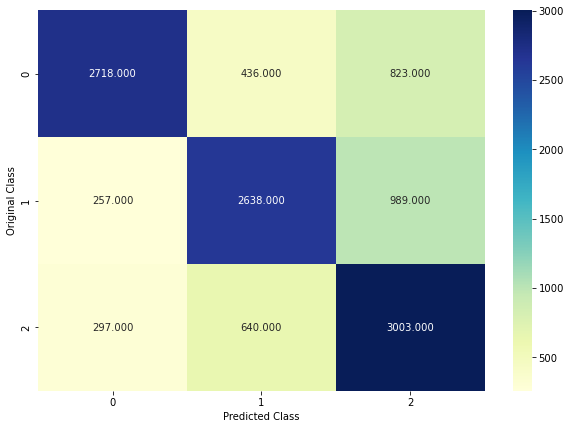

-------------------- Precision matrix (Columm Sum=1) --------------------


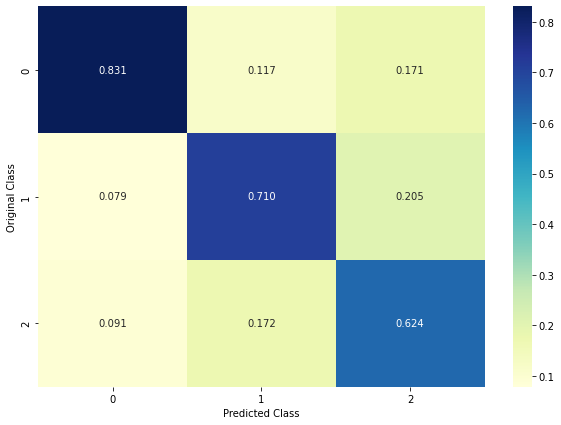

-------------------- Recall matrix (Row sum=1) --------------------


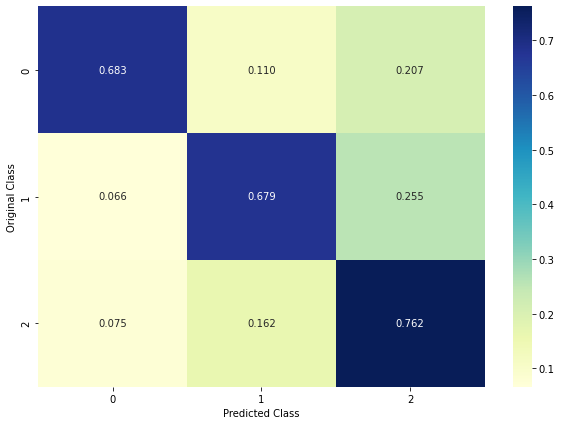




Test Confusion Matrix
-------------------- Confusion matrix --------------------


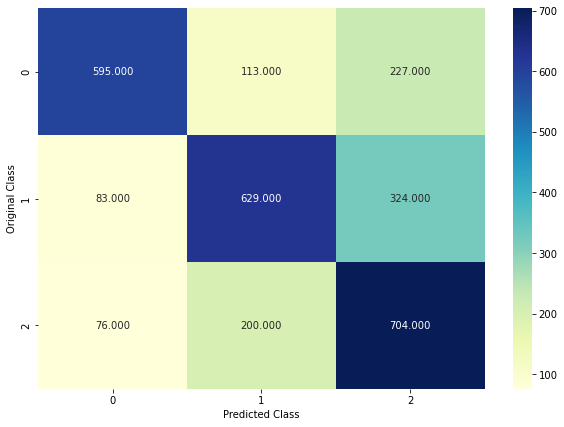

-------------------- Precision matrix (Columm Sum=1) --------------------


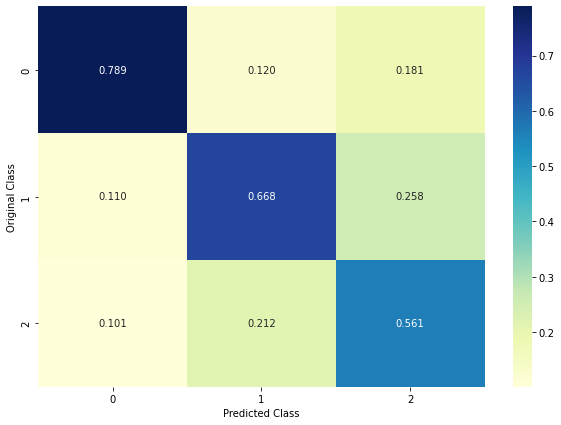

-------------------- Recall matrix (Row sum=1) --------------------


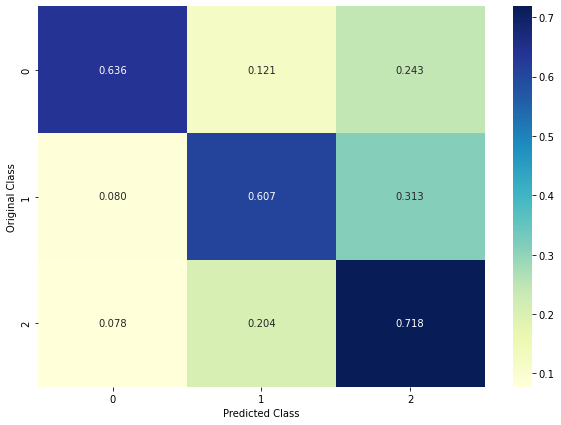

              precision    recall  f1-score   support

           0       0.79      0.64      0.70       935
           1       0.67      0.61      0.64      1036
           2       0.56      0.72      0.63       980

    accuracy                           0.65      2951
   macro avg       0.67      0.65      0.66      2951
weighted avg       0.67      0.65      0.66      2951



In [37]:
cls1 = log_reg_applied(optimal_c, regularization_optimization, nlp_model, X_train, y_train, X_test, y_test)

In [51]:
# msg = input("Enter Message: ")
v = vectorizer.transform(["hamza good"])
print(cls1.predict(v))
cls1.predict_proba(v)

[2]


array([[0.07639767, 0.17911342, 0.74448892]])